In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import json
from scipy import stats

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [52]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2025/ingresos_membresia_ecobici_hsbc.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")
print(f"Tipos de suscripción encontrados: {df_main['tipo_suscripcion'].unique()}")
display(df_main.head())

Rango de fechas: 2024-12-20 00:00:00 a 2024-12-27 00:00:00
Tipos de suscripción encontrados: ['Ecobici HSBC']


,anio,mes_numero,dia_numero,dia_semana,tipo_suscripcion,id_suscripcion,cantidad_Vendida,ingresos_totales_reales,fecha
0,2024,12,20,Friday,Ecobici HSBC,10,6,5694.0,2024-12-20
1,2024,12,21,Saturday,Ecobici HSBC,10,3,2847.0,2024-12-21
2,2024,12,22,Sunday,Ecobici HSBC,10,5,4745.0,2024-12-22
3,2024,12,23,Monday,Ecobici HSBC,10,1,949.0,2024-12-23
4,2024,12,24,Tuesday,Ecobici HSBC,10,1,949.0,2024-12-24


In [53]:
# eliminar columnas innecesarias si existen
columnas_a_eliminar = ['anio', 'mes_numero', 'dia_numero', 'dia_semana', 'tipo_suscripcion', 'id_suscripcion']  # Reemplaza con nombres reales
df_main = df_main.drop(columns=[col for col in columnas_a_eliminar if col in df_main.columns])
print("Columnas innecesarias eliminadas.")
df_main.head()

Columnas innecesarias eliminadas.


,cantidad_Vendida,ingresos_totales_reales,fecha
0,6,5694.0,2024-12-20
1,3,2847.0,2024-12-21
2,5,4745.0,2024-12-22
3,1,949.0,2024-12-23
4,1,949.0,2024-12-24


### Deteccion de ouliers

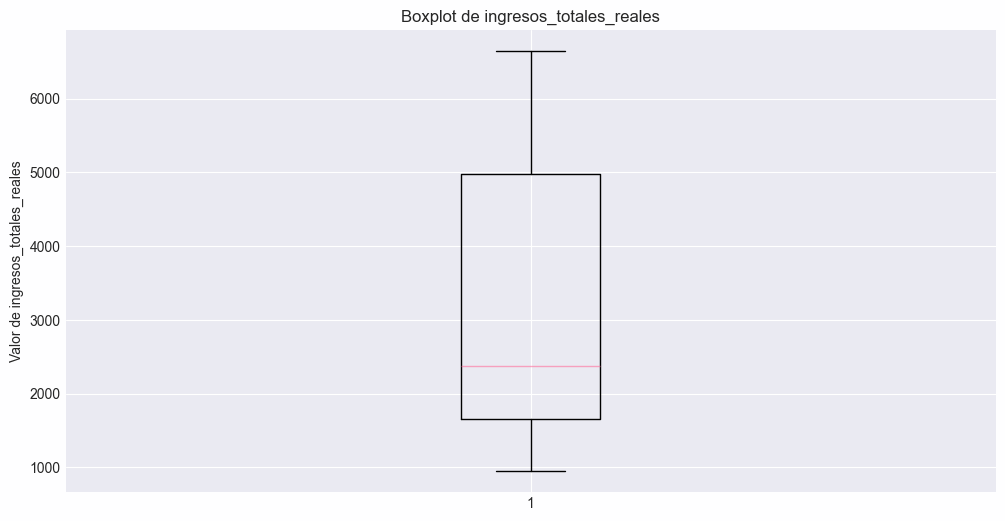

In [54]:
plt.figure(figsize=(12, 6))
plt.boxplot(df_main['ingresos_totales_reales'])
plt.title('Boxplot de ingresos_totales_reales')
plt.ylabel('Valor de ingresos_totales_reales')
plt.show()

In [55]:
# Calculando la mediana de los datos no extremos como valor de imputación
mediana = df_main['ingresos_totales_reales'].median()

# Calculando el IQR para identificar outliers
Q1 = df_main['ingresos_totales_reales'].quantile(0.25)
Q3 = df_main['ingresos_totales_reales'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Imputando outliers con la mediana
df_main['ingresos_totales_reales_imputado'] = np.where(
    (df_main['ingresos_totales_reales'] < lower_limit) | (df_main['ingresos_totales_reales'] > upper_limit),
    mediana,  # Valor de imputación
    df_main['ingresos_totales_reales']  # Mantener el valor original si no es un outlier
)

In [56]:
# Mostrando el efecto de la imputación
print("Valores originales (con outliers):")
# print(df_main['ingresos_totales_reales'].describe())
df_main['ingresos_totales_reales'].describe()

Valores originales (con outliers):


count       8.000000
mean     3202.875000
std      2207.463408
min       949.000000
25%      1660.750000
50%      2372.500000
75%      4982.250000
max      6643.000000
Name: ingresos_totales_reales, dtype: float64

In [57]:
print("\nValores después de la imputación de outliers:")
print(df_main['ingresos_totales_reales_imputado'].describe())


Valores después de la imputación de outliers:
count       8.000000
mean     3202.875000
std      2207.463408
min       949.000000
25%      1660.750000
50%      2372.500000
75%      4982.250000
max      6643.000000
Name: ingresos_totales_reales_imputado, dtype: float64


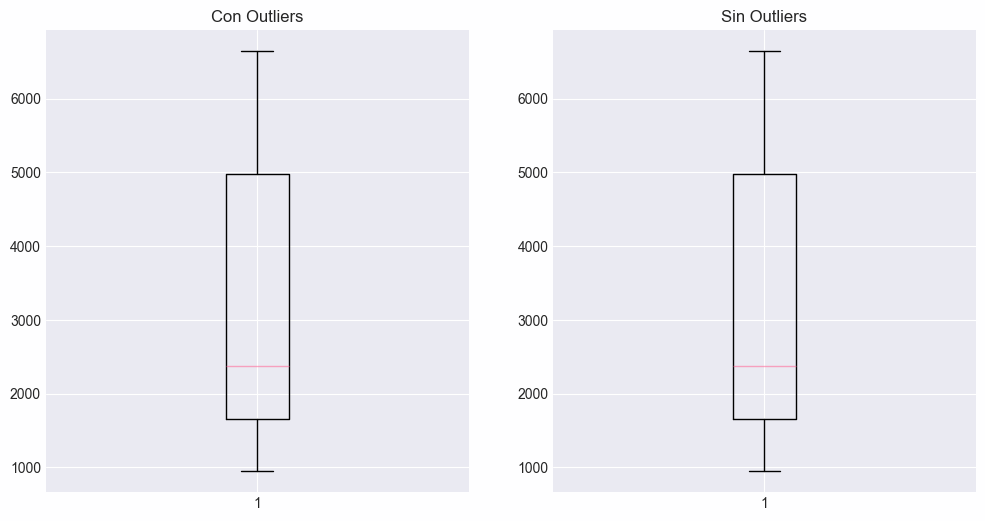

In [58]:
# Visualización de los datos con y sin outliers usando boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(df_main['ingresos_totales_reales'])
plt.title('Con Outliers')

plt.subplot(1, 2, 2)
plt.boxplot(df_main['ingresos_totales_reales_imputado'])
plt.title('Sin Outliers')

plt.show()

In [59]:
df_main.describe()

,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
count,8.000000,8.000000,8,8.000000
mean,3.375000,3202.875000,2024-12-23 12:00:00,3202.875000
min,1.000000,949.000000,2024-12-20 00:00:00,949.000000
25%,1.750000,1660.750000,2024-12-21 18:00:00,1660.750000
50%,2.500000,2372.500000,2024-12-23 12:00:00,2372.500000
75%,5.250000,4982.250000,2024-12-25 06:00:00,4982.250000
max,7.000000,6643.000000,2024-12-27 00:00:00,6643.000000
std,2.326094,2207.463408,NaN,2207.463408


In [60]:
df_main.to_csv('../data/data_cleaned_forecast_2025/ingresos_membresia_ecobici_hsbc_limpio.csv', index=False)
print("Dataset limpio guardado como 'ingresos_membresia_ecobici_hsbc_limpio.csv'.")

Dataset limpio guardado como 'ingresos_membresia_ecobici_hsbc_limpio.csv'.
